In [1]:
import numpy as np
from scipy.special import binom

## non force-sharing

In [5]:
### no sharing

def lifetime_ind(n0, ta, tb, F, ton):
    """
    mean lifetime
    """
    lmd = np.exp(F*x1/(kT))/ta + np.exp(F*x2/(kT))/tb
    gma = (1/ton)/lmd
    tend = 0
    for i in range(1, n0+1):
        tend += ( (1+gma)**(i-1) )/i
    return tend/lmd

def lifetime_var_ind(n0, ta, tb, F, ton):
    """
    lifetime variance
    """
    lmd = np.exp(F*x1/(kT))/ta + np.exp(F*x2/(kT))/tb
    gma = (1/ton)/lmd
    tvar = 0
    part1, part2 = 0, 0
    for i in range(1, n0+1):
        part1 += binom(n0, i)*gma**i/i
        part2 += 2*binom(n0, i)*gma**i/i**2 + 1/i**2
    tvar = part1**2 + part2
    return tvar/(lmd*(1+gma))**2

def lifetime_sens_ind(n0, ta, tb, F, ton):
    """
    lifetime sensitivity
    """
    lmd = np.exp(F*x1/(kT))/ta + np.exp(F*x2/(kT))/tb
    gma = (1/ton)/lmd
    tmean = lifetime_ind(n0, ta, tb, F, ton)
    
    part1 = tmean/(1+gma)
    part2 = ((1+gma)**(n0-1)-1)/lmd
    return (np.exp(F*x2/(kT))/tb)*(part1+part2)/(lmd)
    
def fisherInfo_ind(n0, ta, tb, F, ton, t_max=-1):
    """
    fisher information without force sharing
    """
    if t_max < 0:
        return lifetime_sens_ind(n0, ta, tb, F, ton)**2/lifetime_var_ind(n0, ta, tb, F, ton)
    elif lifetime_ind(n0, ta, tb, F, ton)<t_max:
        return lifetime_sens_ind(n0, ta, tb, F, ton)**2/lifetime_var_ind(n0, ta, tb, F, ton), np.nan
    return np.nan, lifetime_sens_ind(n0, ta, tb, F, ton)**2/lifetime_var_ind(n0, ta, tb, F, ton)

print("tend=", lifetime_ind(100, 1, 1, 0, 1e20), ", expected = ", sum([1/i for i in range(1, 101)])/2)
print("tend=", lifetime_var_ind(100, 1, 1, 0, 1e20), ", expected = ", sum([1/i**2 for i in range(1, 101)])/4)
print("tsens=", lifetime_sens_ind(100, 1, 1, 0, 1e20), ", expected = ", sum([1/i for i in range(1, 101)])/4)
print("tend on=", lifetime_ind(100, 1, 1, 0, 5), ", expected = ",lifetime_ana(100, 1, 1, 0, 5))
print("tsens ton = ", lifetime_sens_ind(100, 1, 1, 10, 5), ", expected = ", (lifetime_ind(100, 1*np.exp(0.0001), 1, 10, 5)- lifetime_ind(100, 1, 1, 10, 5))/0.0001 )


tend= 2.5936887588198103 , expected =  2.5936887588198103
tend= 0.40874597504622306 , expected =  0.40874597504622306
tsens= 1.2968443794099052 , expected =  1.2968443794099052
tend on= 782.474915531496 , expected =  782.4749155314889
tsens ton =  0.02226147817912412 , expected =  0.006402995768838016



## With force-sharing

In [6]:
kT = 4.012
x1 = 1.5
x2 = 2.0

def eta(ta, tb, f):
    """
    compute antigen extraction level
    args:
        ta: APC-Ag lifetime, = 1/kaoff
        tb: BCR-Ag lifetime, = 1/kboff
        f: force
    return:
        eta: extraction level = tb exp(-fx2/kT) / (ta exp(-fx1/kT) + tb exp(-fx2/kT))
    """
    return tb/(ta*np.exp(-f*(x1-x2)/kT)+tb)

def tau(ta, tb,f):
    """
    compute average lifetime of a single 3-body complex
    args:
        ta: APC-Ag lifetime, = 1/kaoff
        tb: BCR-Ag lifetime, = 1/kboff
        f: force
    return:
        tau: = ta exp(-fx1/kT) * tb exp(-fx2/kT) / (ta exp(-fx1/kT) + tb exp(-fx2/kT))
    """
    return ta*np.exp(-f*x1/kT)*eta(ta, tb, f)

def rm(i, ta, tb, f):
    """
    off propensity
    """
    return i*(np.exp(f*x1/(i*kT))/ta + np.exp(f*x2/(i*kT))/tb)

def drm(i, ta, tb, f):
    """
    derivative of rm w.r.t. Eb
    """
    return  i*(np.exp(f*x2/(i*kT))/tb)/rm(i, ta, tb, f)**2

def gm(i, n0, ton):
    """
    on propensity
    """
    return (n0-i)/ton


def lifetime_ana(n0, ta, tb, F, ton=0, method=0):
    """
    average cluster lifetime
    args:
        n0: cluster size
        ta: 1/ka_off
        tb: 1/kb_off
        F: total force,
        ton: 1/kon
        method: which expression to use. Two methods are equivalent
    return:
        mean cluster lifetime
    """
    ave = 0
    for i in range(1, n0+1):
        ave += 1.0/rm(i, ta, tb, F)

    ave0 = ave
    for i in range(1, n0):
        for j in range(i+1, n0+1):
            num, denom = 1, 1
            
            #### method 1
            if method==0:
                if j-i>=j:
                    num = 0
                for k in range(j-i, j):
                    num = num*gm(k, n0, ton)
                    flag=True
                for k in range(j-i, j+1):
                    denom = denom*rm(k, ta, tb, F)
                
            ## method 2
            else:
                for k in range(i, j):
                    num = num*gm(k, n0, ton)
                for k in range(i, j+1):
                    denom = denom*rm(k, ta, tb, F)
            #print(ave)
            ave += num/denom
    return ave


def lifetime_sens(n0, ta, tb, F, ton, dt=1.1):
    """
    calculate lifetime sensitivity numercially using finite difference
    sensitivity = derivative of cluster lifetime w.r.t. Eb
    """
    t1 = lifetime_ana(n0, ta, tb, F, ton)
    t2 =lifetime_ana(n0, ta, tb*1.1, F,ton)
    return (np.log(t2)-np.log(t1))/(np.log(1.1))

def lifetime_sens_ana(n0,ta,tb,F,ton):
    """
    calculate lifetime sensitivity based on analytical expression
    """
    sens= 0
    for i in range(1, n0+1):
        sens += drm(i, ta, tb, F)
        
    for i in range(1, n0):
        for j in range(i+1, n0+1):
            num, denom = 1, 1
            if j-i>=j:
                num = 0
            for k in range(j-i, j):
                num = num*gm(k, n0, ton)
                flag=True
            
            for k in range(j-i, j+1):
                denom = denom*rm(k, ta, tb, F)
                
            dev = 0
            for k in range(j-i, j+1):
                dev += (1- eta(ta, tb, F/k))/k
            #print(ave)
            sens += num*dev/denom   
    
    return sens/lifetime_ana(n0, ta, tb, F, ton)


def lifetime_sens_ana2(n0,ta,tb,F,ton):
    """
    another method to calculate lifetime sensitivity
    """
    sens= 0
    for i in range(1, n0+1):
        sens += drm(i, ta, tb, F)
        
    for i in range(1, n0):
        for j in range(i+1, n0+1):
            num, denom, dev = 1, 1, 0
            
            for k in range(i, j):
                num *= gm(k, n0, ton)
            
            for k in range(i, j+1):
                denom *= rm(k, ta, tb, F)
                
            for k in range(i, j+1):
                dev += rm(k, ta, tb, F)*drm(k, ta, tb, F)
            #print(ave)
            sens += num*dev/denom   
    
    return sens

def lifetime_std_ana(n0, ta, tb, F, ton):
    """
    calculate the lifetime standard deviation
    """
    phi = np.zeros((n0+2, n0+2))
    
    for i in range(1, n0+1):
        for j in range(i+1, n0+1):
            num, denom = 1, 1
            if i>= j:
                num =0
            for k in range(i, j):
                num =num*gm(k, n0, ton)
            for k in range(i, j+1):
                denom = denom*rm(k, ta, tb, F)
            phi[i, j] = num/denom
    
    ## find the mean lifetime list
    T_ave_list = np.zeros(n0+1)
    for n in range(1, n0+1):
        t_ave = 0
        for i in range(1, n+1):
            t_ave += 1.0/rm(i, ta, tb, F)
        
        for i in range(1, n+1):
            for j in range(i+1, n0+1):
                t_ave += phi[i, j]
                
        T_ave_list[n] = t_ave
        
    #print(T_ave_list)
    #print("lifetime=", T_ave_list[n0])
    assert abs(T_ave_list[-1]-lifetime_ana(n0, ta, tb, F, ton))/T_ave_list[-1]<0.000001, "lifetime doesn't match: {0:.3e} vs {1:.3e}".format(T_ave_list[-1], lifetime_ana(n0, ta, tb, F, ton))
    ### calculate the variance
    T_std = 0
    for i in range(1, n0+1):
        T_std += 2*T_ave_list[i]/rm(i, ta, tb, F)
        
        for j in range(i+1, n0+1):
            T_std +=2*T_ave_list[j]*phi[i,j]
    #print("std =", np.sqrt(T_std-T_ave_list[n0]**2)/T_ave_list[n0])
    return np.sqrt(T_std-T_ave_list[n0]**2)

def lifetime_FI(n0, ta, tb, F, ton, max_t=-1):
    """
    compute fisher info in cluster lifetimme
    """
    if max_t <0:
        return (lifetime_sens_ana2(n0, ta, tb, F, ton)/lifetime_std_ana(n0, ta, tb, F, ton))**2
    
    elif lifetime_ana(n0, ta, tb, F, ton)<max_t:
        return (lifetime_sens_ana2(n0, ta, tb, F, ton)/lifetime_std_ana(n0, ta, tb, F, ton))**2, np.nan
    else:
        return np.nan, (lifetime_sens_ana2(n0, ta, tb, F, ton)/lifetime_std_ana(n0, ta, tb, F, ton))**2
                


tmax = 30*60
print("fisher info=",lifetime_FI(100, 20, 5*60, 0, 10*60, tmax), ", expected = ",fisherInfo_ind(100, 20, 5*60, 0, 10*60, tmax) )

fisher info= (0.050822854853250124, nan) , expected =  (0.05073031691358634, nan)


## Generate data

In [23]:
n0 = 30
ta0 = 1
f = 30
tonlist = np.logspace(-3, 2, 11) # use small grid num for fast computing
eblist = np.linspace(-5, 5, 11)

fisher_infoF = np.asarray([[lifetime_FI(n0, ta0, ta0*np.exp(ebi), f, ton) for ton in tonlist] for ebi in eblist])
fisher_infoF_ratio = np.transpose(fisher_infoF.T/fisher_infoF[:, -1])

fisher_infoF_ratio[fisher_infoF<1] = np.nan
fisher_infoF[fisher_infoF<1] = np.nan

## Make plot

In [15]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

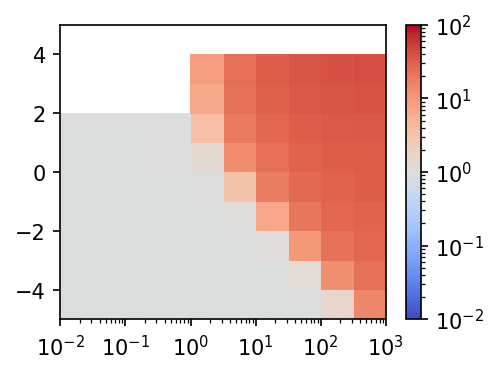

In [24]:
fig, ax = plt.subplots(figsize=(3.5,2.6), dpi=150)
cmap = plt.pcolor(1/tonlist, eblist, fisher_infoF_ratio, 
                  norm=colors.LogNorm(vmin=0.01, vmax=100), 
                  #vmin=0, vmax=50,
                  cmap='coolwarm',
                  rasterized=True)
plt.colorbar(cmap)
plt.xscale('log')
plt.ylim(-5, 5)
plt.xlim(0.01, 1e3)
plt.show()